## 205 - Polynomial and Spline Regression


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# We define the data
house = pd.read_csv('house_sales.csv', sep='\t')
house_98105 = house.loc[house['ZipCode'] == 98105, ]

In [10]:
# This code is performing a more sophisticated version of linear regression that can capture non-linear relationships in housing price data.

    # The formula inside the model:
    
    # "~" means "is modeled by" or "is predicted by." On the left side is our dependent variable (what we're trying to predict) - 
    # the adjusted sale price of houses. On the right side are our independent variables (our predictors).
    
    # The SqFtTotLiving variable appears twice:
    #    - Once as SqFtTotLiving (a linear term)
    #    - Again as np.power(SqFtTotLiving, 2) (a quadratic term)
    # This is what makes it a polynomial regression. By including both the linear and squared terms, we're saying "the relationship 
    # between living space and price might not be strictly linear." 
    # Think about it this way: maybe the first 1000 square feet of a house add a lot of value, but each additional 1000 square feet 
    # adds slightly less value. This curved relationship can be captured by the squared term.

    # The other variables (SqFtLot, Bathrooms, Bedrooms, BldgGrade) are included as regular linear terms. This means we assume their 
    # relationships with price are straight lines.

    # The smf.ols() function comes from the statsmodels formula API (that's what the 'smf' stands for). 
    # It creates an Ordinary Least Squares model using this formula approach. 

    # The data=house_98105 parameter tells it which dataset to use - in this case, housing data from the 98105 zip code area.

model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)

    # This actually runs the regression, finding the best coefficients for each term to minimize the prediction errors. 
result_poly = model_poly.fit()

    # The .summary() method then prints out detailed statistics about how well the model fits the data.
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 21 Jan 2025   Prob (F-statistic):          9.95e-106
Time:                        08:02:15   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## Partial Residual plot for polynomial regression:

The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

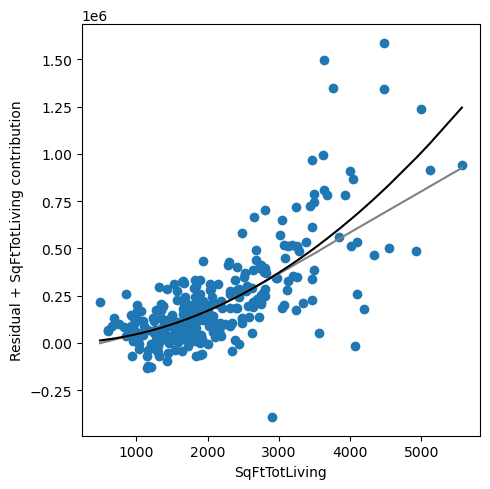

0.0387912816823115


In [13]:
# Partial residual plot: it helps us see the relationship between a specific feature and the outcome variable 
# while accounting for all other variables in the model. 
# This is especially useful in polynomial regression to verify if our non-linear terms are capturing the relationships correctly.


def partialResidualPlot(model, df, outcome, feature, ax):

    # Gets model predictions for all data
        # The function starts by getting the model's predictions for all data points. 
        # These are the values our model would predict GIVEN ALL FEATURES.
    y_pred = model.predict(df)

    
    # Finds which columns the model actually uses
        # In a regression model, we often have many input columns (features) in our DataFrame, but our model might only use some of them. 
        # We need to make sure we're working with exactly the right set of columns that match our model's parameters.

        # "model.params.index" contains all the terms in our model, including:
        # - The intercept (usually called 'const' or 'Intercept')
        # - Original features (like 'SqFtTotLiving')
        # - Transformed features (like 'np.power(SqFtTotLiving, 2)')

        # "df.columns" contains all the columns in our DataFrame
        # They might include features we're not using in the model

        # This line finds the overlap between model terms and DataFrame columns

        # "set()": a set is a special type of collection that has two key properties that make it perfect for this task:
        #   - Sets only store unique values (no duplicates)
        #   - Set operations like intersection are extremely efficient 
        # If we turn that into a set: 
        #   - Sets automatically handle duplicates for us
        #   - The intersection operation efficiently finds common elements
        #   - The result is guaranteed to be unique column names

        # This identifies which columns the model actually uses. Think of it like isolating the ingredients that matter for our recipe. 
        # We make a copy of just these columns to avoid modifying our original data.

    required = set(model.params.index).intersection(df.columns)

    
        
        # "required" is the set containing column names that are used in our model
        # "feature" is the specific column we want to analyze in our partial residual plot (it's one of the function's arguments)
        # "required.add(feature)":
        # Think of "required" as a basket of column names we need. When we call "add(feature)", we're saying "make absolutely sure 
        # our feature of interest is in this basket." If it's already there, nothing changes. If it's not there, it gets added. 
        # This is important because we might be interested in analyzing a feature that wasn't part of our original model.
    
    required.add(feature)


        # "list(required)": 
        # Converts our set back to a list because DataFrame selection needs a list, we use this to select a subset of the df.
    
        # "df[list(required)]":
        # Selects just these columns from our original DataFrame

        # ".copy().astype('float')":
        # Makes a separate copy (so we don't modify our original data)
        # AND converts all values to floating-point numbers

        # The whole line together creates a new DataFrame that:
        #    - Contains only the columns we need for our analysis
        #    - Is separate from our original data (so we can modify it safely)
        #    - Has all numeric values in floating-point format (which is necessary for mathematical calculations)

        # This matters because in the next steps of creating the partial residual plot, we'll need to:
        #    - Zero out all columns except our feature of interest
        #    - Perform mathematical calculations that require floating-point numbers
        #    - Make sure we're working with exactly the right set of columns
    
    copy_df = df[list(required)].copy().astype('float')

    
    # We set all other features to 0, except the one we're studying. 
        # This lets us see how this single feature contributes to the prediction, all else being equal.
    
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df.loc[:, c] = 0.0

         
    # Calculate the feature's isolated contribution
        # using the "copy_df" dataframes with most features zeroed
        # we're seeing how house prices would change if we only varied square footage, while keeping everything else constant (at zero).
    
    feature_prediction = model.predict(copy_df)

    
        # This code creates a DataFrame that contains all the components we need to visualize how well our model captures 
        # the relationship between our feature and the outcome.

        # "df[feature]":   our original feature values (like house square footage), our feature of interest
        # "df[outcome]":   our actual observed values (like house prices)
        # "y_pred":        contains our model's predictions using ALL FEATURES
        # "feature_prediction":    contains predictions when only our feature of interest is non-zero
        # "model.params.iloc[0]":   is the intercept term from our model. 
        #                           From the original model with all parameters - the complete model we fitted initially. 

        # The columns being created:
        #    - 'feature':   This simply stores our original feature values.
        #    - 'residual':  This calculates how far off our full model's predictions were from the actual values.
        #    - 'ypartial':  It represents our feature's isolated contribution to the prediction, with the intercept removed. 
        #                   Remember, feature_prediction came from a version of our data where all other features were set to zero. 
        #                   By subtracting the intercept (model.params.iloc[0]), we get just the effect of our feature.

        # This DataFrame gives us everything we need to create our partial residual plot:
        # - The x-axis will use the 'feature' values
        # - The y-axis will combine 'ypartial' and 'residual' to show both the model's component for this feature 
        #   and how well it fits the data
        # - When we plot 'ypartial + residual' against 'feature', we can see if our model's assumed relationship 
        #   (like a quadratic curve) matches the pattern in the actual data
    
    results = pd.DataFrame({
        'feature': df[feature],               # from the main dataframe, the full model
        'residual': df[outcome] - y_pred,     # actual sale price, minus the predicted sale price from the full model
        'ypartial': feature_prediction - model.params.iloc[0],    # sale price predicted using only one feature, minus the intercept
    })


        # We sort the data by feature value and apply LOWESS smoothing. 
        # This helps us see the underlying pattern more clearly by reducing noise.
    
        # This part is about preparing our data for visualization in a way that will reveal clear patterns.
        # Think of this like arranging points on a graph from left to right. Without sorting, our plot would jump back and forth 
        # as we draw lines between points. By sorting the feature values, we ensure our plot lines will flow smoothly from left to right.

    results = results.sort_values(by=['feature'])


        # LOWESS (Locally Weighted Scatterplot Smoothing) is like drawing a smooth curve through our data points that reveals 
        # the underlying pattern while ignoring noise

        # For each point on our x-axis (feature):
        #    - It looks at nearby points (the "local" part)
        #    - Gives more weight to closer points (the "weighted" part)
        #    - Calculates a weighted average to determine the smoothed y-value
        #    - The "frac=1/3" parameter determines how many nearby points to consider:
        #      If we have 300 data points, it will use 100 points (1/3 of 300) for each calculation.
        #      Smaller fractions (like 1/5) create more wiggly lines that follow the data more closely
        #      Larger fractions (like 1/2) create smoother lines that show broader trends

        # The smoothed values follow the general trend while smoothing out the small ups and downs in the original data.
        # This smoothing is crucial for partial residual plots because:
        #    - It helps us see if our polynomial terms are capturing the true relationship in the data
        #    - It reveals patterns that might suggest we need different polynomial terms
        #    - It makes it easier to spot where our model might be systematically over- or under-predicting

        # syntax: .lowess(the y-values of the observed points, the x-values of the observed points,  
        #                        the fraction of the data used when estimating each y-value.)
        # A lowess function that outs smoothed estimates of endog at the given exog values from points (exog, endog)
        # It returns a 2D NumPy array with the smoothed values.
    
        # returns (x,y)               ( y-values       ,     x-values    , faction)
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)



    # Plots the results
        # The plot shows three key elements:
        #    - Scatter points showing the partial residuals (blue dots)
        #    - A smooth curve showing the general trend (gray line)
        #    - The model's fitted contribution for this feature (black line)
        
        # If your polynomial terms are capturing the relationship well, the gray smoothed line should closely follow the black model line. 
        # Any systematic deviations suggest your model might need adjustment - perhaps adding higher-order terms 
        # or transforming the feature differently.

# POINTS: 
    # X = the value of the feature
    # Y = the sales price predicted by using only the feature - intercept + sales price residuals from the full model
    ax.scatter(results.feature, results.ypartial + results.residual)


    # VERY CONFUSING explanations of how to interpret these 2 lines.
    # It seems like they are built from the same data, just that one is smoothed, so I don't think we are supposed to gain
    # any insignts from comparing them
    
# GREY LINE: Smoothed Actual Data:
    # This plots:
    # x-axis: same feature values
    # y-axis: a smoothed version of (ypartial + residual)
    # The gray line is smoothing the actual scattered points we see in the plot (ypartial + residual), 
    # while the black line shows just ypartial.
    
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')


# BLACK LINE:
    # This plots:
    # x-axis: raw feature values (like square footage)
    # y-axis: feature_prediction - model.params.iloc[0]
    # feature_prediction is what our model predicts when only this feature is non-zero
    # we subtract the intercept to focus on just this feature's contribution
   
    ax.plot(results.feature, results.ypartial, color='black')

    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax



fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params.iloc[2])


In [14]:
# The x-axis shows the house size in square feet (from about 1,000 to 5,000 sq ft)
# The y-axis shows the combined effect of residuals plus the square footage contribution to price (in millions of dollars)
# The blue dots are our actual data points
# The black line shows our model's predicted relationship between square footage and price
# The gray line shows the smoothed relationship in the actual data

# Now, what's this telling us about our model?

# The upward trend in both lines tells us that, as expected, bigger houses tend to be more expensive. 
# But there are some interesting patterns worth noting:
#    - Non-linearity: Notice how both lines curve slightly upward rather than being perfectly straight. 
#      This suggests our decision to use a polynomial term (squared square footage) was reasonable - the relationship between 
#      size and price isn't purely linear.
#    - Model Fit: The black line (our model) follows the gray line (actual trend) fairly closely up until about 3,500 square feet. 
#      This suggests our model is doing a good job capturing the relationship for most typical house sizes.
#    - Spread of Points: The blue dots show considerable scatter around both lines, especially for larger homes. 
#      This tells us that while square footage is important, it's not the only factor determining price - other features 
#      (like location, condition, etc.) also matter significantly.
#    - High-End Homes: For very large homes (>4,000 sq ft), there's more divergence between the black and gray lines, 
#      and the points show more scatter. This suggests our model might be less reliable for predicting prices of very large homes.

In [15]:
# More about plots:

# First, let's understand what we're trying to achieve with a partial residual plot: 
# we want to visualize the true relationship between one feature (like square footage) and our outcome (house price), 
# while accounting for all the other features in our model. This is tricky because in real data, 
# many features affect the price simultaneously.

# Let's break this down step by step:

# First, feature_prediction:
# When we calculate this, we're asking "What would the model predict if ONLY square footage mattered?" 
# We zero out all other features but keep their coefficients in the model. 
# This gives us the model's view of how square footage alone affects price.

# Why subtract the intercept (model.params.iloc[0])?
# The intercept represents a baseline price - what the model predicts when all features are zero. 
# By subtracting it, we isolate just the change in price that comes from square footage. 

# Why add the residuals?
# The residuals (actual price minus predicted price from the full model) contain important information about 
# where our model's predictions were wrong. By adding them back, we're essentially saying "Show me the relationship between 
# square footage and price, adjusted for what we know about where our model makes mistakes."


# When we plot this (example) point, its y-value would be:
# ypartial + residual = $200,000 + $20,000 = $220,000
# This final value tells us: "For a 2000 sq ft house, this is how much square footage contributes to the price, adjusted for both:
#    - The baseline price (by subtracting intercept)
#    - What we know about our model's prediction errors (by adding residual)"

# This combination is powerful because:
#    - It shows us the "pure" effect of square footage (ypartial)
#    - It includes information about where our model might be systematically wrong (residuals)
#    - It allows us to see if our assumed relationship (like a quadratic curve) matches what the data actually suggests

# When we plot many such points and add our smoothed line, we can see if our model's assumed relationship between square footage and price 
# (usually shown as a black line) matches the actual pattern in the data (usually shown as a gray line).


## Splines

In [20]:
# This performs a regression analysis using the ordinary least squares (OLS) method with a spline term in the formula. 

# This will create df – degree = 6 – 3 = 3 internal knots

# "bs()": refers to B-spline terms, which are flexible basis functions used for modeling non-linear relationships.

# df=6: This creates 6 degrees of freedom, meaning we're essentially dividing the range of square footage into segments. 
# Think of it like placing 6 control points that help shape our curve.

# degree=3: 
# Indicates a cubic spline (degree 3 polynomial) for smooth, flexible modeling.

# It's like drawing a curve through your data, but instead of forcing one rigid shape across all house sizes, 
# we're allowing different curved shapes for different ranges of square footage

formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

# "smf.ols": A convenient interface from statsmodels for creating an OLS regression model using a formula.


model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()


# When we print the summary, we'll see coefficients for each spline basis function (there will be several of them) 
# instead of just coefficients for square footage and squared square footage. These coefficients work together to create a smooth, 
# flexible curve that can capture more complex relationships between house size and price.

print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 21 Jan 2025   Prob (F-statistic):          7.10e-104
Time:                        08:02:17   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


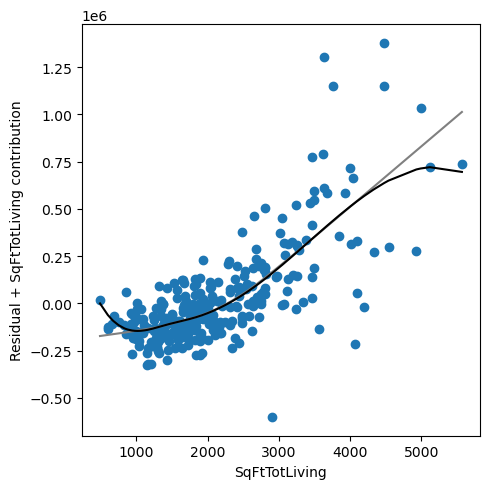

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

## Generalized Additive Models

### Using statsmodels


In [24]:
# This code fits a Generalized Additive Model (GAM) to data using the statsmodels library. 

    # - GLMGam: A class for fitting GAMs in statsmodels.
    # - BSplines: A specific type of smoother that uses B-splines for flexible modeling of relationships 
    # between predictors and the outcome variable.

from statsmodels.gam.api import GLMGam, BSplines

    # Predictors: The independent variables being used to model the outcome 
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']

    # The dependent variable (AdjSalePrice), representing the adjusted sale price of houses.
outcome = 'AdjSalePrice'


# Setting up the Smoother:

    # x_spline: Data frame with predictor variables.

x_spline = house_98105[predictors]

    # - x_spline: Subset of the data with the predictors.
    # - df: Specifies the degrees of freedom for the splines. 
    # Here, SqFtTotLiving has more complexity (10 degrees of freedom), and other variables have 3 each ([3] * 4 elements, list).
    # SqFtTotLiving has 10 degrees of freedom, meaning a more flexible smooth curve.
    # - degree: Specifies the polynomial degree for each B-spline
    # Cubic splines (degree = 3) are used for SqFtTotLiving, and quadratic splines (degree = 2) for the rest.

bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)


# Penalization Weights:

    # alpha: Array of penalties applied to the smooth terms to control overfitting. 
    # Here, no penalization is applied (0 for all terms).
alpha = np.array([0] * 5)



    # - formula: A formula specifying the relationship between predictors and the outcome.
    # - data: The data frame containing the variables (house_98105).
    # - smoother: The BSplines object defining how the predictors are smoothed.
    # - alpha: Penalization weights applied to the smooth terms.
formula = ('AdjSalePrice ~ SqFtTotLiving + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')


# Creates a Generalized Additive Model (GAM) object using the GLMGam class from statsmodels

    # "GLMGam.from_formula" is a class method that creates a GAM model from a formula. 
    # GAMs allow for a mix of linear and non-linear relationships between the predictors and the response variable, 
    # where the non-linear relationships are specified using smoothing functions like B-splines.

# 2. Parameters
    # - formula
    # This is a formula string that specifies the model to be fitted:
    # The formula syntax follows the standard used in patsy and statsmodels, where ~ separates the outcome from the predictors.
    # - data:
    # This is the dataset (a pandas DataFrame) containing the variables used in the formula.
    # The dataset must have columns corresponding to all the variables specified in the formula.
    # - smoother:
    # This defines the smoothing mechanism for the non-linear relationships in the model.
    # Here, bs is a B-spline smoother object created earlier using BSplines:
    # - alpha:
    #  specifies the penalization weights for the smooth terms in the GAM.
    # Penalization helps to avoid overfitting by discouraging overly complex models.
    # Here, all weights are set to 0, meaning no penalization is applied. 
    # This allows the smoothing splines to fit the data as flexibly as possible.

    # GLMGam.from_formula combines all these inputs to create the GAM object:
    #     - It parses the formula to identify the outcome and predictors.
    #     - It links the predictors to their specified smoothers (e.g., bs for B-splines).
    #     - It incorporates penalization through the alpha parameter.

    # The resulting gam_sm is a GLMGam object, which is an instance of a GAM model. This object contains:
    #    - The parsed formula.
    #    - The dataset (house_98105).
    #    - Information about the smoothers (e.g., splines).
    #    - Model parameters (e.g., penalization weights).
    # The model is ready to be fitted to the data using the fit() method:
    
gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)

# Fitting the Model:
    # fit(): Fits the GAM to the data using maximum likelihood estimation.
res_sm = gam_sm.fit()

    # summary(): Displays a summary of the fitted GAM, including coefficients, smooth term effects, and goodness-of-fit statistics.
print(res_sm.summary())

# Purpose
# This code models the relationship between housing features and the adjusted sale price. 
# By using splines, it captures non-linear relationships for the predictors, providing more flexibility than a traditional linear model.

# Output
# The summary will include:
# - Estimated coefficients for the predictors and their significance.
# - Smoothing parameters for the splines and their effect on the model.
# - Model fit statistics (e.g., AIC, log-likelihood).




                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                   295.00
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               Identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Tue, 21 Jan 2025   Deviance:                   8.1039e+12
Time:                        08:02:17   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

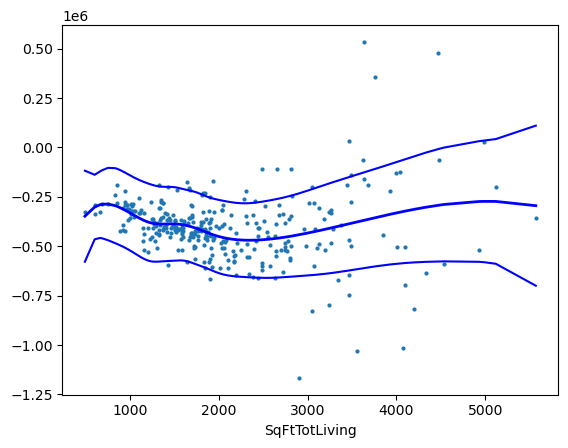

In [91]:
# Plotting:

# res_sm:
    # This variable represents a fitted GAM model. This object contains the results of fitting the model to your data, 
    # including information about the predictors, coefficients, and smoothing terms.
# plot_partial():
    # This is a method of the fitted GAM object. It is used to visualize the partial effect of a specific predictor variable in the model. 
    # Partial plots show how the outcome variable is related to a single predictor, holding other predictors constant.
# 0:
    # This argument specifies the index of the predictor variable for which you want to plot the partial effect. 
    # In this case, it's the first predictor (index 0).
# cpr=True:
    # cpr stands for component-plus-residual plot.
    # When cpr=True, the plot overlays a component-plus-residual (partial residual) plot on the partial effect plot. 
    # The CPR plot helps visualize how well the model's smoothing function fits the data.
# ;  :
    # This semicolon is optional in Python. It suppresses the output of the plotting command, which might otherwise display 
    # additional details or objects in the console.

res_sm.plot_partial(0, cpr=True);

# Purpose:
# This line generates a plot that shows the smoothed effect of the first predictor in the GAM model, along with the partial residuals. 
# This helps evaluate:
#    - Whether the model's smooth fits the data well.
#    - If there are any outliers or patterns in the residuals that might indicate model misspecification.

# Example Use Case:
# In a scenario where you're modeling the relationship between environmental factors and recycling rates, this plot could show 
# how temperature (predictor 0) influences the outcome while controlling for other factors.


    # THE THREE LINES:
# Middle Line (Smooth Effect):
# The central curve represents the estimated partial effect of the square footage of living space (SqFtTotLiving) 
# on the selling price of the house. This line is the result of the smoothing function in the Generalized Additive Model (GAM). 
# It shows how the model predicts selling price changes as the square footage increases, after accounting for the effect of other variables.
# Upper and lower:
# They represent the upper and lower bound of the confidence interval (e.g., 95%) for the estimated partial effect. 
# They indicates the lowest and highest plausible values for the smooth estimate given the data and the model.

# The confidence bands provide a measure of uncertainty around the central estimate:
#    - A narrow confidence band (closer lines) indicates more confidence in the smooth estimate.
#    - A wider band suggests more variability in the model's predictions, often due to less data in certain regions or more noise.

# Default Confidence Level:
# The confidence intervals typically correspond to a 95% confidence level by default. 
# This means that the model estimates the range where the true effect is likely to lie 95% of the time.

# Calculation:
# The confidence intervals are derived using the variance of the smooth term and its associated standard errors, 
# which are computed as part of the model fitting process. For a GAM, this involves:
#    - The uncertainty in the smoothing spline (from penalization).
#    - The variance of the residuals (from the model error).


    # OBSERVATIONS
# Data Points (Dots): The blue dots are the partial residuals, showing how the observed data deviate from the estimated trend.
# Nonlinearity: The smooth curve suggests that the relationship between square footage and price is not perfectly linear. For instance:
#    - A steeper slope at smaller square footage indicates a larger price increase for smaller houses.
#    - The curve flattens at larger square footage, suggesting diminishing returns on price for very large homes.

    # INTERPRETATION
# The plot shows the effect of the square footage of living space (SqFtTotLiving) on the house selling price, based on a GAM.
# The curve in the middle represents the estimated relationship between square footage and selling price, 
# holding all other variables in the model constant

# The Middle Line:
# - Initially (left side), there’s a positive trend, meaning that as square footage increases, the selling price tends to rise.
# - As square footage becomes very large (e.g., beyond 3000), the curve flattens, indicating diminishing returns — 
#   additional square footage contributes less to price increases.

# The Upper and Lower Lines (Confidence Bands):
# - These lines show the confidence interval for the estimated smooth effect. By default, this is often a 95% confidence interval.
# - The true relationship is likely to lie between these two lines. A narrower gap indicates greater certainty in the estimate, 
#   while a wider gap suggests more variability or less confidence in the prediction.
# - Between 1000 and 3000 square feet, the bands are relatively narrow, suggesting that the model's estimate is more reliable here.
# - Beyond 4000 square feet, the bands widen significantly, suggesting fewer data points in this range or greater variability 
#   in house prices for large homes.

#  The Dots (Partial Residuals):
# The blue dots are the partial residuals, showing the observed data points after accounting for other variables. 
# These allow you to see how well the smooth trend captures the data:
#    - If the dots align closely with the smooth line, it indicates that the model fits the data well.
#    - Outliers (dots far from the line) could indicate areas where the model struggles or where there might be noise in the data.


    # INSIGHTS:
# The relationship between square footage and selling price is not linear.
# Initially, increasing square footage significantly boosts price, but the effect diminishes for larger homes.
# The model is more confident in the smooth estimate for homes with square footage in the 1000–3000 range (narrow bands).
# For very large homes (e.g., >4000 sq ft), there’s more uncertainty, likely due to fewer observations or higher variability.
# For areas with high uncertainty (e.g., >4000 sq ft), you may want to investigate further. Are there enough data points in this range? 
# Could other factors (e.g., location or luxury features) explain the variability?


## Using pyGAM


In [62]:
# Data Preparation

    # A list of column names that serve as input features for the model:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
    # The target variable, which represents the adjusted sale price of houses. This is the variable the model is trying to predict.
outcome = 'AdjSalePrice'


    # X: The feature matrix (independent variables). The ".values" extracts the values of the predictors as a NumPy array.
    # y: The target variable (dependent variable) as a NumPy array.

    # ".values" :
    # most machine learning libraries, including pyGAM, require the input data to be in a numeric array format .
    # Libraries like pyGAM, scikit-learn, and others perform mathematical operations on the data. 
    # These computations require the data to be in a numerical format, and NumPy arrays are highly optimized for this purpose.
    # DataFrames from pandas include metadata like column names and indices, which are not needed for these computations 
    # and might even cause errors in certain operations.
    # pyGAM expects the feature matrix X to be a 2D numeric array (in this case is (313, 5) )
    #    - Rows represent observations (individual data points).
    #    - Columns represent predictors (features).
    # While a pandas DataFrame can conceptually serve this purpose, pyGAM's internal functions typically expect the input in a simplified, 
    # efficient format like a NumPy array. Using .values ensures this compatibility.

X = house_98105[predictors].values
y = house_98105[outcome]


    # Specifying the Model
    # This creates a linear Generalized Additive Model (GAM). GAMs are flexible models that allow nonlinear relationships 
    # between predictors and the outcome.
    
    # The first predictor (SqFtTotLiving) is modeled nonlinearly using a smoothing spline.
    # The other predictors are modeled linearly.
    
    #s(0, n_splines=12):
    #    - The s() function specifies a smoothing spline for a predictor.
    #    - 0 refers to the first predictor in the X matrix (SqFtTotLiving).
    #    - n_splines=12 specifies the number of spline basis functions to use for the smooth. More splines provide more flexibility 
    #      but can risk overfitting.
    
    # l(1), l(2), l(3), l(4):
    #     - The l() function specifies linear terms for the predictors.
    #     - For l(1), l(2), etc., it means the model will treat SqFtLot, Bathrooms, Bedrooms, and BldgGrade as linear predictors.

gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))

    # Training the Model

# gridsearch:
    # This method performs a hyperparameter search to optimize the smoothness penalty for each term in the model. 
    # It selects the best combination of penalties by evaluating the model's performance on the data.
    # The model automatically determines how smooth or wiggly each spline should be, 
    # balancing model fit and complexity (to avoid overfitting).
    # This is an essential step for ensuring the smooth terms provide a good approximation of the relationship 
    # between predictors and the outcome.

gam.gridsearch(X, y)

# Printing the Summary
    # This prints a detailed summary of the fitted GAM model, including:
    #    - The estimated coefficients for each predictor.
    #    - The smoothness penalties applied to each term.
    #    - Confidence intervals for the effects.
    #    - Measures of model performance, such as:
    #        - R-squared: Proportion of variance explained by the model.
    #        - GCV (Generalized Cross-Validation): A measure of model fit that penalizes complexity.

print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1676
                                                Scale:                                    29480381715.8292
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

/var/folders/g2/3877pmxd2q126pc05fpf439m0000gn/T/ipykernel_1392/213036163.py:41: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [58]:
# INTERPRETING THE SUMMARY


            # OVERALL METRICS
# Model Details
# Distribution: "NormalDist":
# The response variable (AdjSalePrice) is assumed to follow a normal distribution, which is typical for regression tasks.

# Link Function: "IdentityLink":
# This indicates a linear relationship between the model's prediction and the response variable.

# Performance Metrics

# Effective Degrees of Freedom (EDoF): 7.6772:
    # This represents the total complexity of the model. It is the sum of the smoothness penalties applied to splines and linear terms. 
    # A higher EDoF indicates more model flexibility.

# Log Likelihood: "-7833.1159":
    # Measures how well the model explains the observed data. Higher (less negative) values indicate better fit.

# AIC (Akaike Information Criterion): "15683.5863"
    # A measure of model quality, penalizing model complexity. Lower values indicate a better trade-off between goodness-of-fit 
    # and complexity.

# GCV (Generalized Cross-Validation Score): 30,838,885,095.1676
    # Represents the average prediction error of the model. Lower GCV indicates better generalization to unseen data.

# Pseudo R-Squared: 0.8117
    # This indicates that 81.17% of the variability in the response variable (AdjSalePrice) is explained by the model. 
    # This is a strong fit.


            # FEATURE SPECIFIC DETAIL
# Column Headers
    # Feature Function:
        # Indicates whether the feature is modeled as a spline (s()) or linear term (l()).
    # Lambda:
        # The regularization strength (smoothness penalty) applied to the feature's term. 
        # Larger values impose stronger penalties, making the term smoother (less flexible).

    # Rank:
        # The number of basis functions or parameters used for that term.

    # EDoF (Effective Degrees of Freedom):
        # Measures how much flexibility a term has. Nonlinear features (splines) have higher EDoF, 
        # while linear terms typically have EDoF close to 1.
        # The Effective Degrees of Freedom (EDoF) can be a fractional number because they represent the model's complexity 
        # as a continuous measure, not just a count of parameters. 
        # In traditional linear models, each parameter typically contributes 1 degree of freedom. 
        # However, in GAMs, where terms like splines are used, the flexibility of the model is controlled by smoothing penalties. 
        # The EDoF is a measure of how much the model uses the available flexibility to fit the data. 

    # P > x (p-value):
        # Indicates whether the feature significantly contributes to the model. Lower values (e.g., < 0.05) indicate statistical significance. Significance codes:
        #     - ***: Highly significant.
        #     - **: Significant.
        #     - *: Moderately significant.
        #     - .: Marginal significance.
        #     - Blank: Not significant.

# INTERPRETATION OF EACH FEATURE:
    
    #s(0) (SqFtTotLiving):
        # Nonlinear term: Modeled with a spline.
        # EDoF: 4.3: This indicates moderate flexibility in the relationship between SqFtTotLiving and AdjSalePrice.
        # P-value: 1.11e-16 (***): Highly significant, suggesting SqFtTotLiving has a strong effect on house price.

    #l(1) (SqFtLot):
        # Linear term: Modeled as a linear relationship.
        # EDoF: 0.9: A simple linear term.
        # P-value: 2.35e-10 (***): Highly significant. Lot size contributes meaningfully to house prices.

    #l(2) (Bathrooms):
        # Linear term.
        # EDoF: 0.8: Indicates a near-linear relationship.
        # P-value: 8.45e-01: Not significant. Bathrooms do not significantly affect the adjusted sale price in this model.

    # l(3) (Bedrooms):
        # Linear term.
        # EDoF: 0.9.
        # P-value: 3.79e-01: Not significant. Number of bedrooms does not significantly affect the price.

    # l(4) (BldgGrade):
        # Linear term.
        # EDoF: 0.8.
        # P-value: 1.11e-16 (***): Highly significant. Building grade (quality of construction) strongly influences house prices.

    # Intercept:
        # P-value: 9.14e-01: The intercept is not significant, but it provides a baseline adjustment for the model.

# TAKEAWAYS

# Main Drivers of Price:

    # SqFtTotLiving (square footage of living space) and BldgGrade (building quality) are the most significant predictors 
    # of adjusted sale price.
    # SqFtLot (lot size) is also significant but has a weaker effect than the above.

# Non-Significant Predictors:
    # Bathrooms and Bedrooms are not statistically significant in this model. 
    # This could indicate that their effect on price is already captured indirectly by other variables like BldgGrade.

# Nonlinear Relationship:
    # The spline term for SqFtTotLiving captures the nonlinear effect of square footage on price 
    # (e.g., diminishing returns for larger houses).

# Model Fit:
    # The Pseudo R-Squared of 0.8117 indicates that the model explains most of the variability in house prices, 
    # making it a strong predictor.

#  Warnings:
    # There is a caution about model identifiability when mixing splines and linear terms, 
    # which may cause p-values to appear misleadingly significant. This is something to keep in mind when interpreting results.


# ACTIONABLE INSIGHTS

    # Focus on features like SqFtTotLiving, SqFtLot, and BldgGrade for predicting house prices, as they have the most substantial effects.
    # Investigate why Bathrooms and Bedrooms are insignificant—perhaps they are correlated with other predictors or lack sufficient variability.
    # Validate the results (e.g., by testing on a separate dataset) to confirm the model's predictions and mitigate issues with identifiability.    


(313, 5)

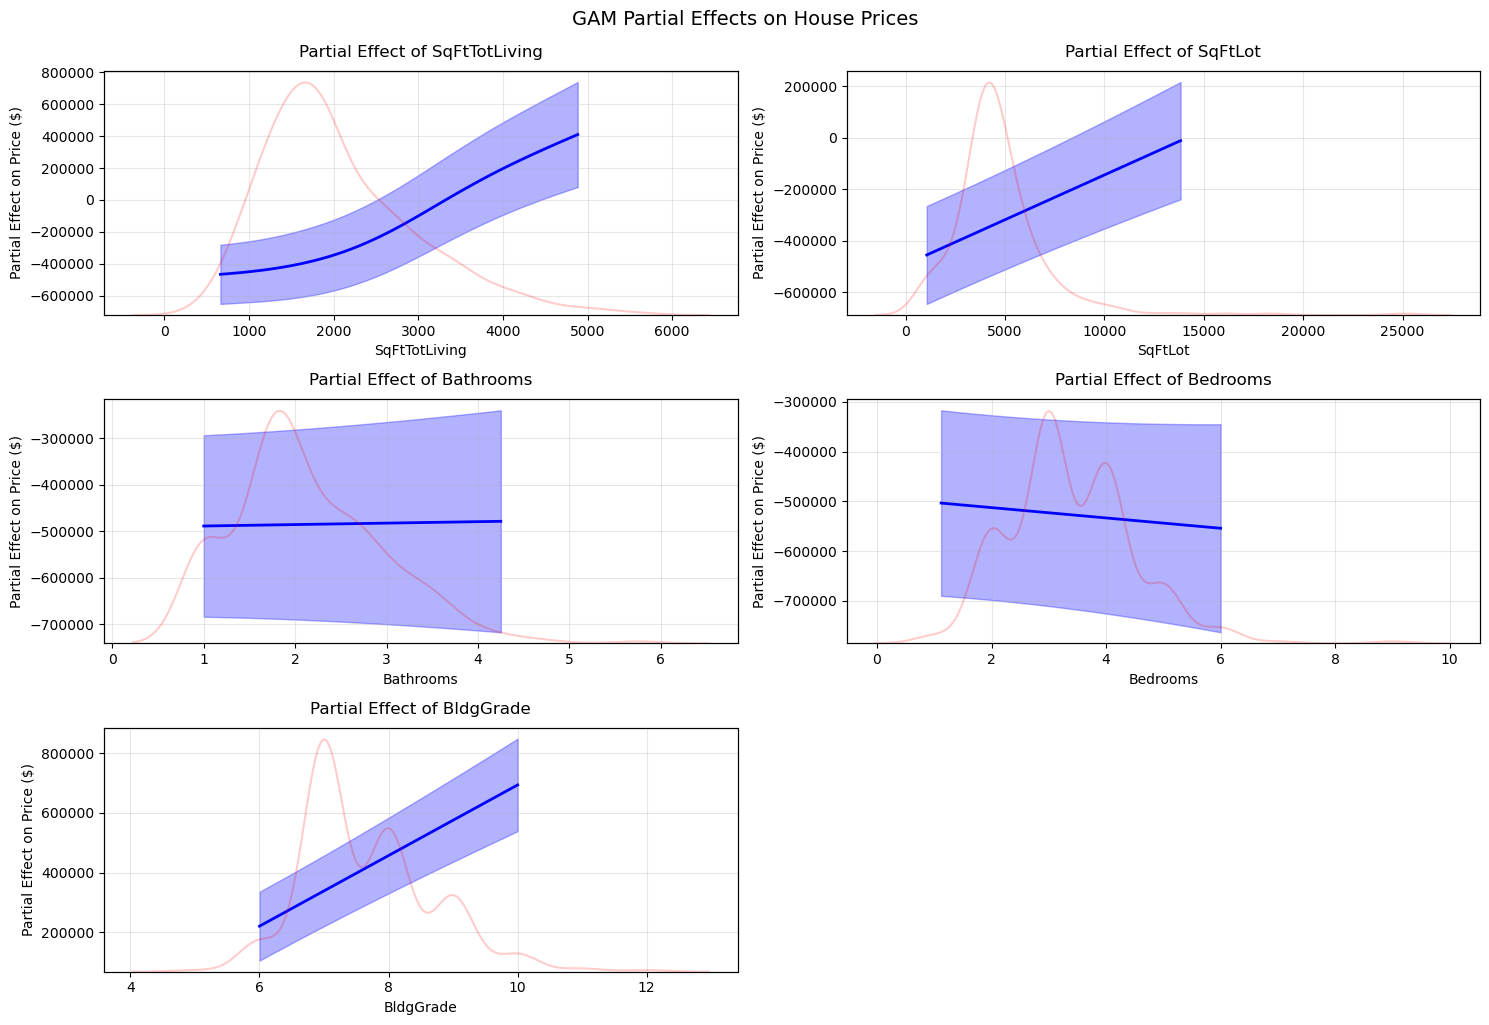

In [121]:
# This code creates a specialized graph for each feature in your house price model
# What are we trying to show? 
# For each feature, we want to see how it affects house prices when we change just that one feature while keeping everything else constant. 
# It's like asking "How does the price change if we only change the square footage?"


# This code defines a function plot_gam_effects() that visualizes the partial effects of each feature in a Generalized Additive Model (GAM). 
# The function creates a grid of plots, where each plot represents the effect of a single feature, its confidence intervals, 
# and its data distribution. 

def plot_gam_effects(gam, X, feature_names, figsize=(15, 10)):
    """
    Create partial effect plots for each feature in the GAM model.
    
    This implementation correctly handles partial effects and their confidence
    intervals by using GAM's built-in prediction methods and proper statistical
    transformations.
    
    Parameters:
    -----------
    gam : pygam.LinearGAM
        Fitted GAM model
    X : array-like
        Input features used to fit the model
    feature_names : list
        List of feature names corresponding to the columns in X
    figsize : tuple
        Size of the entire plot grid.
    """
    # Set up the plotting environment
        # The code calculates the number of rows (n_rows) needed for the subplots based on the number of features (n_features). 
        # Each row contains two plots.
        # The figure (fig) and axes (axes) are created using plt.subplots.
    n_features = X.shape[1]   # Count how many features we have
    n_rows = (n_features + 1) // 2   #  Create enough rows for all our plots, 2 plots per row, rounded up
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)   # Create the grid of plots

        # axes is a 2D NumPy array with shape (2, 3).
        # Each element in this array corresponds to an individual subplot in the grid.
        # in fact later we refer to individual plots with   ax = axes[i]
    
    if n_rows == 1:
        axes = np.array([axes]).reshape(1, -1)
    axes = axes.flatten()
    
    
        # Plot partial effects for each feature
        # This creates 100 evenly spaced points between the smallest and largest values of our feature (ignoring extreme outliers). 
        # Think of it as creating a smooth range of values to test, like checking house prices for every possible square footage 
        # from smallest to largest.

        # Looping Through Each Feature
        # For each feature, the loop sets up an individual subplot (ax).
        # The following operations occur for this feature:
    
    for i, feature in enumerate(feature_names):
        ax = axes[i]
        
            # Generate feature values for prediction
            # Use percentiles to avoid edge effects
            # "x_values" is a grid of values spanning from the 1st to 99th percentiles of the feature's values in the dataset. 
            # This avoids extreme outliers that could distort the plot.
        x_values = np.linspace(
            np.percentile(X[:, i], 1),
            np.percentile(X[:, i], 99),
            100
        )

        
            # Building the Prediction Matrix
            # The matrix XX is initialized with zeros, and only the column corresponding to the current feature (i) is filled with x_values.
            # This isolates the effect of the feature being analyzed while holding other features constant (at zero).
        XX = np.zeros((len(x_values), X.shape[1]))
        XX[:, i] = x_values

        
        # Get predictions and confidence intervals
            # gam.predict(XX) computes the partial effect of the feature (predicted values).   
            # the full model is used, but only one feature is filled with actual values, 
            # while the others are kept constant (typically at zero or their mean values, depending on how XX is set up).
            # XX is a matrix where the column corresponding to the feature of interest (i) is filled with actual values (x_values).
            #  All other columns are set to zero
            # This ensures that the predictions focus only on the effect of the feature being analyzed, 
            # isolating its contribution to the outcome.

            # The result of gam.predict(XX) represents the partial effect of the isolated feature on the target variable
            # holding all other features constant.
        predictions = gam.predict(XX)

            # gam.confidence_intervals() calculates the 95% confidence interval for these predictions.
            # This returns a  2D array with shape (n_samples, 2), where n_samples is the number of rows in XX.
            # Each row contains the lower and upper bounds of the confidence interval for the corresponding prediction.
            # confidence.shape = (100, 2)
        confidence = gam.confidence_intervals(XX, width=.95)
        
            # Plotting the Partial Effect
            #The main effect (predictions) is plotted as a blue line.
        ax.plot(x_values, predictions, color='blue', linewidth=2, 
                label='Partial Effect')


            # Add confidence intervals
            # Confidence intervals are shaded around the line for visualization.
        ax.fill_between(x_values, 
                       confidence[:, 0],
                       confidence[:, 1],
                       alpha=0.3, color='blue',
                       label='95% Confidence Interval')
        
            # Add data distribution using kernel density estimate
            # A secondary y-axis (ax2) is added to show the kernel density estimate (KDE) of the feature's values (data distribution).
            # This helps visualize the range and density of the feature's values in the dataset.
    
            # The method ax.twinx() in Matplotlib is used to create a secondary y-axis that shares the same x-axis as the primary axis (ax).
            # When you call ax.twinx(), it creates a new Axes object (ax2) that shares the same x-axis as the original axis (ax), 
            # but has its own independent y-axis.
            # This means you can plot a second set of data on the same graph but measure it using a different scale on the y-axis.
            # Both the primary (ax) and the secondary axis (ax2) share the same horizontal (x) values, so their data is aligned on the x-axis.
            # The y-axis for ax2 can have a completely different range and scale than the primary y-axis (ax).
            # This is useful when plotting two different types of data that vary on different scales but are related by the x-axis.
        ax2 = ax.twinx()
        sns.kdeplot(data=X[:, i], ax=ax2, color='red', alpha=0.2,
                    label='Data Distribution')
        ax2.set_ylabel('')
        ax2.set_yticks([])
        
        # Customize the plot
        ax.set_title(f'Partial Effect of {feature}', fontsize=12, pad=10)
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel('Partial Effect on Price ($)', fontsize=10)
        ax.grid(True, alpha=0.3)
        
    
    # Removing empty subplots (if the number of features is odd):
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    return fig

    # Create and display the plot
fig = plot_gam_effects(gam, X, predictors)

    # Adding the Title and Showing the Plot        
fig.suptitle('GAM Partial Effects on House Prices', fontsize=14, y=1.02)
plt.show()

    This code defines a function plot_gam_effects() that visualizes the partial effects of each feature in a Generalized Additive Model (GAM). The function creates a grid of plots, where each plot represents the effect of a single feature, its confidence intervals, and its data distribution. Here's an explanation of how it works step-by-step:
Code Breakdown
1. Parameters of the Function

    gam: A fitted GAM model (e.g., from pyGAM.LinearGAM).
    X: Input feature matrix used for training the model.
    feature_names: List of feature names corresponding to the columns in X.
    figsize: Size of the entire plot grid.

2. Setting Up the Plotting Environment

plt.style.use('seaborn')
n_features = X.shape[1]
n_rows = (n_features + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=figsize)

    The code calculates the number of rows (n_rows) needed for the subplots based on the number of features (n_features). Each row contains two plots.
    The figure (fig) and axes (axes) are created using plt.subplots.

3. Looping Through Each Feature

for i, feature in enumerate(feature_names):
    ax = axes[i]

    For each feature, the loop sets up an individual subplot (ax).
    The following operations occur for this feature:

4. Generating Feature Values for Predictions

x_values = np.linspace(
    np.percentile(X[:, i], 1),
    np.percentile(X[:, i], 99),
    100
)

    x_values is a grid of values spanning from the 1st to 99th percentiles of the feature's values in the dataset. This avoids extreme outliers that could distort the plot.

5. Building the Prediction Matrix

XX = np.zeros((len(x_values), X.shape[1]))
XX[:, i] = x_values

    The matrix XX is initialized with zeros, and only the column corresponding to the current feature (i) is filled with x_values.
    This isolates the effect of the feature being analyzed while holding other features constant (at zero).

6. Predictions and Confidence Intervals

predictions = gam.predict(XX)
confidence = gam.confidence_intervals(XX, width=.95)

    gam.predict(XX) computes the partial effect of the feature (predicted values).
    gam.confidence_intervals() calculates the 95% confidence interval for these predictions.

7. Plotting the Partial Effect

ax.plot(x_values, predictions, color='blue', linewidth=2, label='Partial Effect')
ax.fill_between(x_values, confidence[:, 0], confidence[:, 1],
                alpha=0.3, color='blue', label='95% Confidence Interval')

    The main effect (predictions) is plotted as a blue line.
    Confidence intervals are shaded around the line for visualization.

8. Adding Data Distribution

ax2 = ax.twinx()
sns.kdeplot(data=X[:, i], ax=ax2, color='red', alpha=0.2, label='Data Distribution')

    A secondary y-axis (ax2) is added to show the kernel density estimate (KDE) of the feature's values (data distribution).
    This helps visualize the range and density of the feature's values in the dataset.

9. Customizing and Cleaning the Plot

    Titles, labels, and grids:

ax.set_title(f'Partial Effect of {feature}', fontsize=12, pad=10)
ax.set_xlabel(feature, fontsize=10)
ax.set_ylabel('Partial Effect on Price ($)', fontsize=10)
ax.grid(True, alpha=0.3)

Removing empty subplots (if the number of features is odd):

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

10. Adding the Title and Showing the Plot

fig.suptitle('GAM Partial Effects on House Prices', fontsize=14, y=1.02)
plt.show()

    Adds a main title for the figure and adjusts the layout to avoid overlaps.

# Output Explanation
# Each Plot:
    # X-axis: The feature values (e.g., SqFtTotLiving).
    # Y-axis: Partial effect of the feature on the response variable (e.g., house prices).
    # Blue Line: Modeled effect of the feature.
    # Shaded Area: 95% confidence interval for the effect.
    # Red Density Plot: Distribution of the feature values.

In [151]:
bath_median = house_98105['Bathrooms'].median()
bath_mean = house_98105['Bathrooms'].mean()
print(f" 'Bathroom'  median is {bath_median}. Mean is {bath_mean:.2f}")

 'Bathroom'  median is 2.0. Mean is 2.13


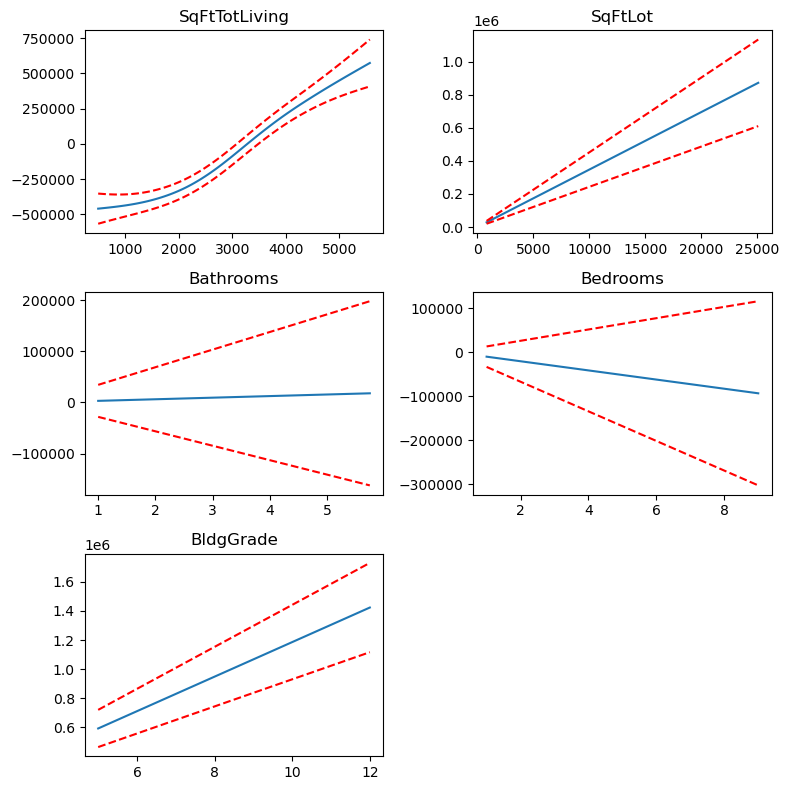

In [161]:
# OTHER VISUALIZATION
#  The code creates partial dependence plots that show how different features individually affect the model's predictions.

    # Plot setup:
    # This creates a figure with a 2x3 grid of subplots, each subplot being part of an 8x8 inch figure. 
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)


    # We define the features we want to analyze:
titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']


    
for i, title in enumerate(titles):

    # This determines which subplot to use. (// = Floor division)
    ax = axes[i // 2, i % 2]

    # creates a grid of values for the feature being plotted. This helps create smooth curves by evaluating the model at many points.
    # The term parameter in gam.generate_X_grid(term=i) specifies which feature (or term) in the model you want to generate 
    # the grid of values for. 
    # It essentially tells the method to create a range of values for the specified term while holding all other terms constant.
    # The "generate_X_grid" method in PyGAM is used to generate a grid of input values (X) 
    # to evaluate the model for visualizations or analysis
    # It creates a grid for a specific term (a feature in the model) based on the range of values observed in the data.
    # It keeps all other features fixed, typically to their mean or other default values.
    # "term=i": Specifies the index of the term (feature) in the GAM model for which the grid should be created.
    
    XX = gam.generate_X_grid(term=i)


    # Two plots are created for each feature:
    #    - A solid line showing the main partial dependence (how the feature affects predictions)
    #    - A dashed red line showing confidence intervals (the uncertainty in the prediction)

    # The "partial_dependence()" function calculates how the model's predictions change when we vary one feature 
    # (specified by term=i) while holding all other features at their average values. 
    #    - XX[:, i] represents the range of values for our feature of interest
    #    - "gam.partial_dependence(term=i, X=XX)" calculates the model's predicted output at each of these values
    #    - The [1] index selects the upper or lower confidence bound
    #    - c='r', ls='--' makes the confidence interval line red and dashed
    
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))

    # The "width=.95" parameter in the second line creates 95% confidence intervals, showing how certain the model is about its predictions
    
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);


# Since we have 5 features but 6 subplot spaces (2×3 grid), we hide the bottom-right subplot.     
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# The resulting visualization would show how each housing feature independently influences the model's predictions, 
# with confidence intervals indicating the reliability of these relationships. 
# This is particularly useful for understanding which features have linear vs. non-linear relationships with the target variable
# and how strong these relationships are.


